# Analytic Report and Research Proposal

## The dataset
The data I used here was part of the official datasets used on the Medicare.gov Nursing Home Compare Website provided by the Centers for Medicare & Medicaid Services. The data was last updated on Apr 25, 2018, and contains results from Year 2017.


This dataset includes data on many different attributes of the nursing home rating system, and contains more than 15,000 providers nationwide in the US. Utilizing this dataset, I can explore how is the general nursing home care quality between different states and investigate what factors may affect a provider's rating.

Among the many different variables, the relevant variable used in this analysis are:

__PROVNUM__ - Federal Provider Number

__STATE__ - Provider State

__OWNERSHIP__ - Nature of organization that operates a provider of services

__RESTOT__ - Average Number of Residents per Day

__BEDCERT__ - Number of Certified Beds

__OVERALL_RATING__ - Overall Rating

__TOTHRD__ - Reported Total Nurse Staffing Hours per Resident per Day

__PTHRD__ - Reported Physical Therapist Staffing Hours per Resident Per Day

__WEIGHTED_ALL_CYCLES_SCORE__ - Total Weighted Health Inspection Score

More detailed description of the nursing home rating system can be found in the [Technical User's Guide](https://www.cms.gov/medicare/provider-enrollment-and-certification/certificationandcomplianc/downloads/usersguide.pdf).

Now, let's load the data and clean it a little bit:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import us
%matplotlib inline

#Load data
df = pd.read_csv('ProviderInfo_Download.csv', index_col='PROVNUM', encoding='Windows-1252')
df1 = df.filter(['STATE', 'OWNERSHIP', 'OVERALL_RATING', 'WEIGHTED_ALL_CYCLES_SCORE', 
                 'RESTOT', 'BEDCERT', 'TOTHRD', 'PTHRD']).dropna() #Removing data with missing values
df1['WEIGHTED_ALL_CYCLES_SCORE'] = df1['WEIGHTED_ALL_CYCLES_SCORE'].apply(pd.to_numeric)

Now that our data is kind of clean. We can start exploring.

## Q1: Which state has the most 5-star overall rating providers?
Now we can ask some specific questions based on the data. For example, say we want to know which state has the most good quality nursing home providers.

The most intuitive way is to just plot out the number of 5-star providers in each state. However, this result may not be the most relevant, as bigger states which have more population and more providers in general would just have more 5-star providers. Therefore, I normalized the number of total providers and 5-star providers by state population (census data obtained [separately](https://www.census.gov/data/tables/2017/demo/popest/state-total.html)). This way, we can truly see which state has the most available nursing home care and the best of them for its people.

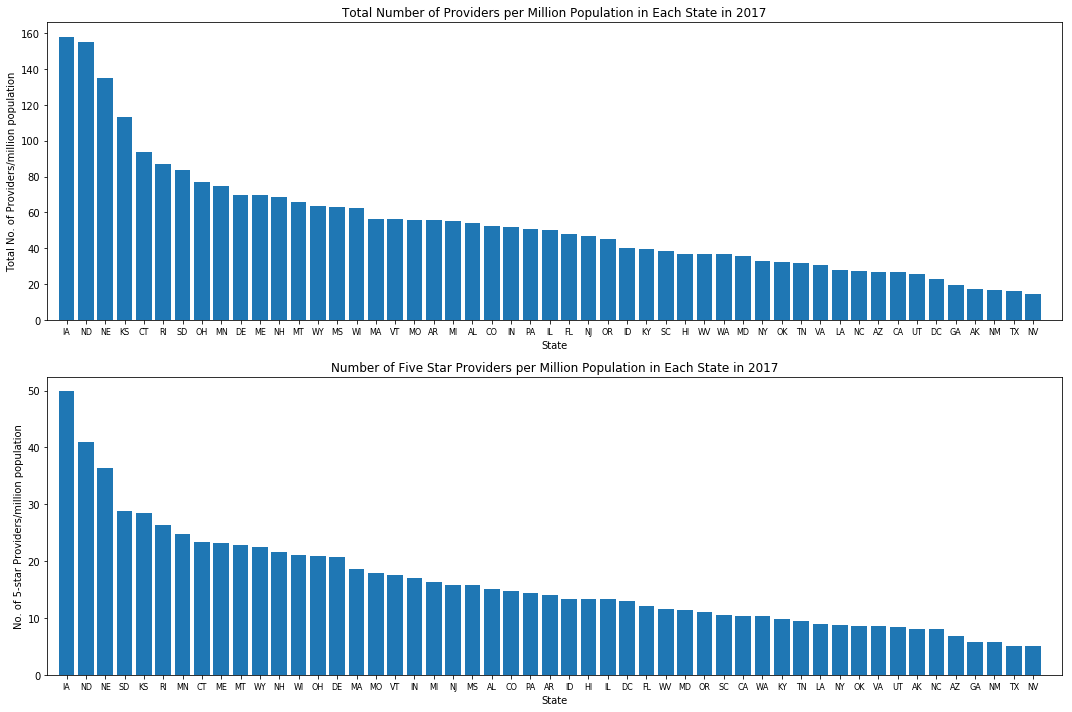

In [2]:
#Eliminating Guam, as no other terratories are included. To simplify the analysis,
#we want to focus on main states.
df1=df1[df1.STATE != 'GU']

#How many providers in total does each state have?
five_star_provider = pd.DataFrame()
five_star_provider['Total_Provider_No'] = df1['STATE'].value_counts().tolist()

#How many providers with 5-star ratings does each state have?
five_star = df1.loc[df1['OVERALL_RATING']==5, :]
count = pd.Series(pd.Categorical(five_star['STATE'], categories=df1['STATE'].unique()))
five_star_provider['STATE'] = count.value_counts().keys().tolist()
five_star_provider['Five_Star_No'] = count.value_counts().tolist()

#Get census data on state population.
census = pd.read_excel('nst-est2017-01.xlsx')
census.columns = census.iloc[2]
census.columns = census.columns.fillna('state')
census = census.iloc[8:59]
census['state'] = census.state.str.replace('.' , '')

statez = us.states.mapping('name', 'abbr')
census['abbr'] = census['state'].map(lambda a: statez[a])
census2017 = census[['abbr', 2017.0]]

merged_inner = pd.merge(left=five_star_provider,right=census2017, left_on='STATE', right_on='abbr')
merged_inner = merged_inner.drop(columns=['abbr'])
merged_inner['five_norm'] = merged_inner['Five_Star_No'] * 1000000 / merged_inner[2017.0]
merged_inner['total_norm'] = merged_inner['Total_Provider_No'] * 1000000 / merged_inner[2017.0]

#Plot the total provider numbers and five star providers normalized by population.
plt.figure(figsize=(15, 10))

plt.subplot(211)
label = merged_inner.sort_values(['total_norm'], ascending=False)['STATE']
index = np.arange(len(label))
width = 0.8
plt.bar(index, merged_inner.sort_values(['total_norm'], ascending=False)['total_norm'], width)
plt.xlabel('State', fontsize=10)
plt.ylabel('Total No. of Providers/million population', fontsize=10)
plt.xticks(index, label, fontsize=8,)
plt.title('Total Number of Providers per Million Population in Each State in 2017')
plt.gca().set_xlim(left=-1, right=len(index)+0.5)

plt.subplot(212)
label = merged_inner.sort_values(['five_norm'], ascending=False)['STATE']
index = np.arange(len(label))
width = 0.8
plt.bar(index, merged_inner.sort_values(['five_norm'], ascending=False)['five_norm'], width)
plt.xlabel('State', fontsize=10)
plt.ylabel('No. of 5-star Providers/million population', fontsize=10)
plt.xticks(index, label, fontsize=8,)
plt.title('Number of Five Star Providers per Million Population in Each State in 2017')
plt.gca().set_xlim(left=-1, right=len(index)+0.5)
plt.tight_layout()
plt.show()

From these two charts, we can see that Iowa (IA), North Dakota (ND), and Nebraska (NE) are the top 3 for both total number of providers and the number of 5-star providers per 1,000,000 population.

## Q2: Does different profit types of provider have different ratings and Health Inspection Scores?
Next, I wonder whether the nature of the organization running the nursing homes (i.e. Non profit, For profit, and government-run) makes a difference in their quality.

Besides overall rating, we also have another measure of quality, health inspection score. It is one of the measures that gets taken into consideration for the final overall rating. Since it's included in the dataset, we can also explore this as a quality measure.

*Note: Counterintuitively, the higher the health inspection score, it actually means there's more health deficiencies, and thus lower quality.*

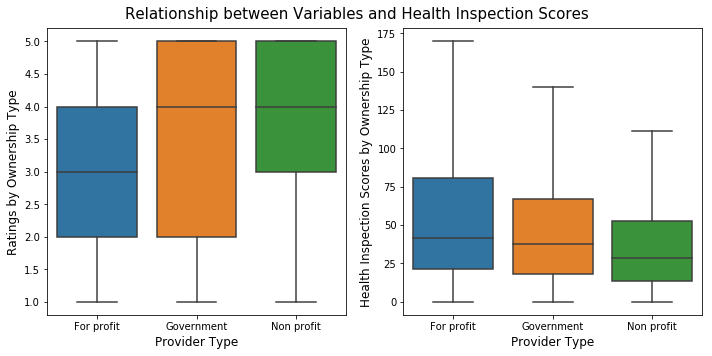

In [3]:
#Does different profit types of provider have different ratings and Health Inspection Scores?
df1['type'] = df1['OWNERSHIP'].str.split('-').str[0].str.strip()

fig = plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
sns.boxplot(y='OVERALL_RATING', x='type', data=df1)
plt.ylabel('Ratings by Ownership Type', fontsize=12)
plt.xlabel('Provider Type', fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(y='WEIGHTED_ALL_CYCLES_SCORE', x='type', data=df1, showfliers=False)
plt.ylabel('Health Inspection Scores by Ownership Type', fontsize=12)
plt.xlabel('Provider Type', fontsize=12)

plt.suptitle('Relationship between Variables and Health Inspection Scores', fontsize=15)
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

It does look like there is quality difference between the different types of providers. Overall, nonprofit nursing homes have a high overall rating and lower health inspection score, whereas the for profit nursing homes has the reverese.

## Q3: What factors can affect the overall ratings and health inspection scores for a for profit organization?
Now I want to explore a little bit about which factors may contribute to the qualities of the nursing homes, for example, the number of residents, the number of beds, and the staffing situation of nurses and physical therapists. Since from the last question, we can see that the for profit providers have a wide range of ratings and scores, so for this exploratory analysis, I am going to focus on the for profit providers.

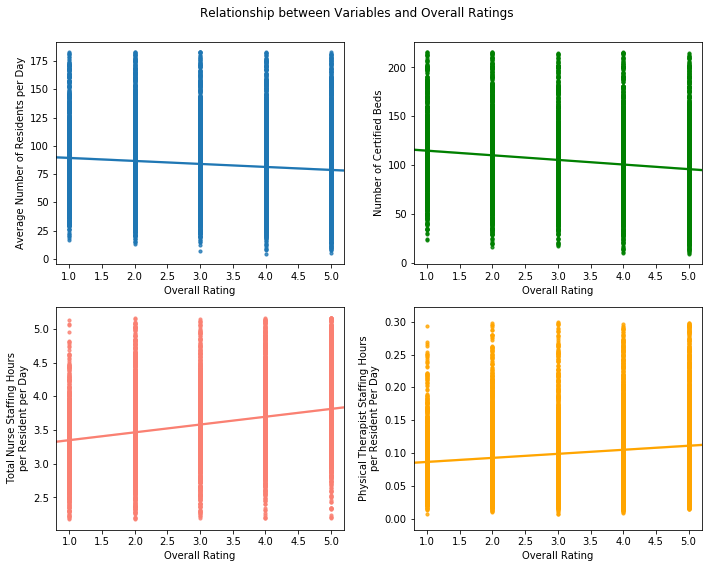

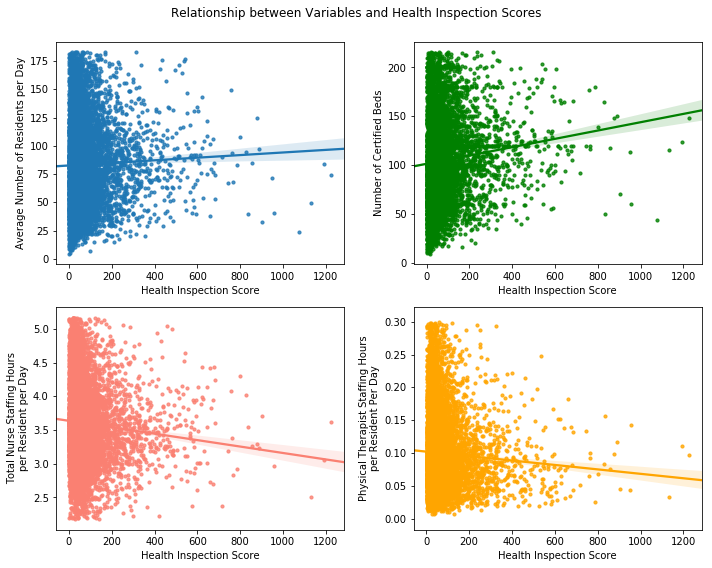

In [4]:
#Let's focus on the data of for-profit providers.
for_profit = df1[df1['type'] == 'For profit']

#Clear the outliers.
RESTOT_no_flier = for_profit[np.abs(for_profit.RESTOT-for_profit.RESTOT.mean())<=(2*for_profit.RESTOT.std())] 
BEDCERT_no_flier = for_profit[np.abs(for_profit.BEDCERT-for_profit.BEDCERT.mean())<=(2*for_profit.BEDCERT.std())]
TOTHRD_no_flier = for_profit[np.abs(for_profit.TOTHRD-for_profit.TOTHRD.mean())<=(2*for_profit.TOTHRD.std())]
PTHRD_no_flier = for_profit[np.abs(for_profit.PTHRD-for_profit.PTHRD.mean())<=(2*for_profit.PTHRD.std())]
PTHRD_no_flier = PTHRD_no_flier[(PTHRD_no_flier != 0).all(1)]

#Is there any relationship between overall ratings and
#the number of certified beds or residents, or the staffing situation?
fig = plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.regplot(x='OVERALL_RATING', y='RESTOT', data=RESTOT_no_flier, scatter_kws={'s':10})
plt.xlabel('Overall Rating')
plt.ylabel('Average Number of Residents per Day')

plt.subplot(2, 2, 2)
sns.regplot(x='OVERALL_RATING', y='BEDCERT', data=BEDCERT_no_flier,
            scatter_kws={'s':10}, color='g')
plt.xlabel('Overall Rating')
plt.ylabel('Number of Certified Beds')

plt.subplot(2, 2, 3)
sns.regplot(x='OVERALL_RATING', y='TOTHRD', data=TOTHRD_no_flier,
            scatter_kws={'s':10}, color='salmon')
plt.xlabel('Overall Rating')
plt.ylabel('Total Nurse Staffing Hours\nper Resident per Day')

plt.subplot(2, 2, 4)
sns.regplot(x='OVERALL_RATING', y='PTHRD', data=PTHRD_no_flier,
            scatter_kws={'s':10}, color='orange')
plt.xlabel('Overall Rating')
plt.ylabel('Physical Therapist Staffing Hours\nper Resident Per Day')

plt.suptitle('Relationship between Variables and Overall Ratings')
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

#Is there any relationship between health inspection scores and
#the number of certified beds or residents, or the staffing situation?
fig = plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.regplot(x='WEIGHTED_ALL_CYCLES_SCORE', y='RESTOT', data=RESTOT_no_flier, scatter_kws={'s':10})
plt.xlabel('Health Inspection Score')
plt.ylabel('Average Number of Residents per Day')

plt.subplot(2, 2, 2)
sns.regplot(x='WEIGHTED_ALL_CYCLES_SCORE', y='BEDCERT', data=BEDCERT_no_flier,
            scatter_kws={'s':10}, color='g')
plt.xlabel('Health Inspection Score')
plt.ylabel('Number of Certified Beds')

plt.subplot(2, 2, 3)
sns.regplot(x='WEIGHTED_ALL_CYCLES_SCORE', y='TOTHRD', data=TOTHRD_no_flier,
            scatter_kws={'s':10}, color='salmon')
plt.xlabel('Health Inspection Score')
plt.ylabel('Total Nurse Staffing Hours\nper Resident per Day')

plt.subplot(2, 2, 4)
sns.regplot(x='WEIGHTED_ALL_CYCLES_SCORE', y='PTHRD', data=PTHRD_no_flier,
            scatter_kws={'s':10}, color='orange')
plt.xlabel('Health Inspection Score')
plt.ylabel('Physical Therapist Staffing Hours\nper Resident Per Day')

plt.suptitle('Relationship between Variables and Health Inspection Scores')
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

It looks like number of residents and number of beds have a negative relationship with overeall rating, and positive relationship with health inspection score.

In contrast, the nurse and physical therapist staffing hours positively correlate with overall rating, and negatively correlate with health inspection score.

# Future Research
With these information at hand, we may be able to use machine learning to predict how well a provider is going to do for future health inspections and the overall ratings, based on which state it is in, what nature of the organization it is, and what kind of resource it has. And based on this prediction, we may even be able to propose potential recommendations on how to improve its quality to get a high rating.